# Mineração de Dados Massivos
## Analise de descrição de mercadorias de Notas Fiscais Eletrônicas

# Ambiente

## Bibliotecas

In [1]:
# Iniciando Ambiente
import numpy as np, pandas as pd, time, random
import datetime as dt

import nltk
from nltk.corpus import stopwords
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import rcParams
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

# Se necessário, descomente as linhas a seguir para ler as stopwords
nltk.download('stopwords')
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## Módulos

In [2]:
# Módulos de código de programação
#!pip install import-ipynb
import import_ipynb

# Carga de Arquivos
from carga import doCarga

# Tratamento de Dados         
from tratamento import doTratamento


importing Jupyter notebook from carga.ipynb
<class 'pandas.core.frame.DataFrame'>
Int64Index: 719921 entries, 0 to 879062
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Remetente      719921 non-null  object
 1   NovaDescricao  719921 non-null  object
 2   Categoria      719921 non-null  object
dtypes: object(3)
memory usage: 22.0+ MB
importing Jupyter notebook from tratamento.ipynb


## Variáveis de Ambiente

In [3]:
# Pasta aonde estão os dados
diretorio = '..\\dados\\'
#diretorio = "F:\\Weisner\\Documentos\\MEGA Estudos\\UNB - MDM - Mineração de Dados Massivos\\Artigo\\" 


In [4]:
# Contador de tempo
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Duração: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

# Carga dos dados

## Abrir arquivo

In [5]:
# Carrega os dados
dfNotas = doCarga(diretorio, opcao=3)
print ("{} registros carregados".format(dfNotas.size))

2159763 registros carregados


## Processa se necessário

In [6]:
# doTratamento(dfNotas, diretorio)

In [7]:
# Amostra dos dados
dfNotas

,Remetente,NovaDescricao,Categoria
0,Fornecedor 001,CACHACA SAO FRANCISCO 12X970M,30.0simsim
1,Fornecedor 001,CACHACA YPIOCA EMP.OURO,30.0simsim
2,Fornecedor 001,CACHACA YPIOCA OURO,30.0simsim
3,Fornecedor 001,CACHACA YPIOCA PRATA,30.0simsim
4,Fornecedor 002,BB CACHACA SAGATIBA PURA (12) GF,30.0simsim
...,...,...,...
730469,Fornecedor 178,LED DISCO SUPIMPA BR 6500K 12W BIV,42.0nãonão
730470,Fornecedor 097,MARGARIDA PAPEL DOURADO METALIZADO,42.0nãonão
730471,Fornecedor 157,EXPOSITOR HUGY,42.0nãonão
879061,Fornecedor 014,LIMAO ESPREMIDO COCINERO,40.0simnão


In [8]:
# Remove a coluna de Remetente
dfNotas = dfNotas.drop(columns=['Remetente'])

# Balanceamento

## Situação - AS-IS

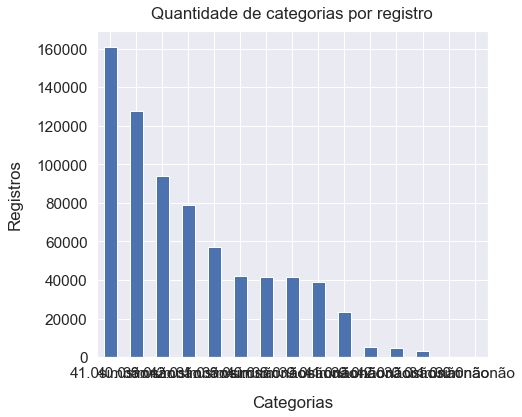

In [9]:
sns.set(font_scale=1.4)
dfNotas['Categoria'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Categorias", labelpad=14)
plt.ylabel("Registros", labelpad=14)
plt.title("Quantidade de categorias por registro", y=1.02);

plt.savefig('imagens/DisDesbalanceada.png', bbox_inches='tight');

In [10]:
dfNotas['Categoria'].value_counts()

41.0simnão    161005
40.0simnão    127642
38.0simnão     94179
42.0simnão     78789
31.0simsim     57000
38.0simsim     42003
40.0nãonão     41739
38.0nãonão     41409
39.0simnão     39237
41.0nãonão     23224
39.0nãonão      5457
42.0nãonão      4956
30.0simsim      3090
31.0nãonão       182
30.0nãonão         9
Name: Categoria, dtype: int64

In [11]:
# Separa os contadores
count_class_0, count_class_1, count_class_2, count_class_3, count_class_4, count_class_5, count_class_6, count_class_7, count_class_8, count_class_9, count_class_10, count_class_11, count_class_12, count_class_13, count_class_14 = dfNotas['Categoria'].value_counts()

In [12]:
# Divide datasets por classes
df_class_0 = dfNotas[dfNotas['Categoria'] == "41.0simnão"]
df_class_1 = dfNotas[dfNotas['Categoria'] == "40.0simnão"]
df_class_2 = dfNotas[dfNotas['Categoria'] == "38.0simnão"]
df_class_3 = dfNotas[dfNotas['Categoria'] == "42.0simnão"]
df_class_4 = dfNotas[dfNotas['Categoria'] == "31.0simsim"]
df_class_5 = dfNotas[dfNotas['Categoria'] == "38.0simsim"]
df_class_6 = dfNotas[dfNotas['Categoria'] == "40.0nãonão"]
df_class_7 = dfNotas[dfNotas['Categoria'] == "38.0nãonão"]
df_class_8 = dfNotas[dfNotas['Categoria'] == "39.0simnão"]
df_class_9 = dfNotas[dfNotas['Categoria'] == "41.0nãonão"]
df_class_10 = dfNotas[dfNotas['Categoria'] == "39.0nãonão"]
df_class_11 = dfNotas[dfNotas['Categoria'] == "42.0nãonão"]
df_class_12 = dfNotas[dfNotas['Categoria'] == "30.0simsim"] # Tamanho escolhido
df_class_13 = dfNotas[dfNotas['Categoria'] == "31.0nãonão"] # 182 - poucos registros
df_class_14 = dfNotas[dfNotas['Categoria'] == "30.0nãonão"] # 9 - insignificante

# Equipara os tamanhos 30.0simsim
# Foram equiparados ao tamanho da classe 3
#MaxSize = df_class_3.size 
#MaxSize = 3000 # df_class_3.size 
MaxSize = 2500 # df_class_3.size 

## Undersampling

In [13]:
# Faz o undersampling a partir de amostras aleatórias
df_class_0 = df_class_0.sample(MaxSize)
df_class_1 = df_class_1.sample(MaxSize)
df_class_2 = df_class_2.sample(MaxSize)
df_class_3 = df_class_3.sample(MaxSize)
df_class_4 = df_class_4.sample(MaxSize)
df_class_5 = df_class_5.sample(MaxSize)
df_class_6 = df_class_6.sample(MaxSize)
df_class_7 = df_class_7.sample(MaxSize)
df_class_8 = df_class_8.sample(MaxSize)
df_class_9 = df_class_9.sample(MaxSize)
df_class_10 = df_class_10.sample(MaxSize)
df_class_11 = df_class_11.sample(MaxSize)
df_class_12 = df_class_12.sample(MaxSize)

## Oversampling

In [14]:
# Random Oversampling
df_class_13 = df_class_13.sample(MaxSize, replace=True)

## Reagrupa

In [15]:
# Agrupa novamente
dfAjustado = pd.concat([df_class_0, df_class_1, df_class_2, df_class_3, df_class_4, df_class_5, df_class_6, df_class_7, df_class_8, df_class_9, df_class_10, df_class_11, df_class_12, df_class_13], axis=0)
dfAjustado = dfAjustado.sample(frac = 1)

## Resultado - Dataset Balanceado

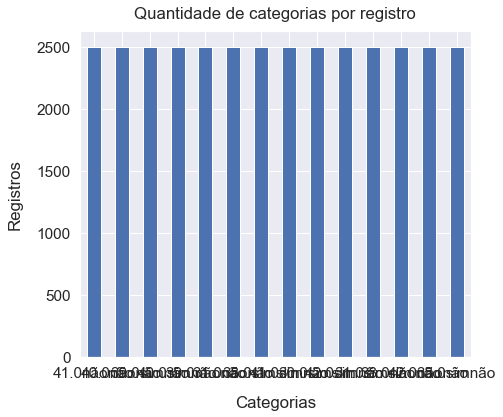

In [16]:
# Gera imagem do balanceamento ajustado
sns.set(font_scale=1.4)
dfAjustado['Categoria'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Categorias", labelpad=14)
plt.ylabel("Registros", labelpad=14)
plt.title("Quantidade de categorias por registro", y=1.02);
plt.savefig('imagens/DisBalanceada.png', bbox_inches='tight');  

In [17]:
dfAjustado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 160014 to 29993
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   NovaDescricao  35000 non-null  object
 1   Categoria      35000 non-null  object
dtypes: object(2)
memory usage: 820.3+ KB


In [18]:
dfAjustado = dfAjustado.sample(frac=1).reset_index(drop=True)

# Scikit-learn

In [19]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import numpy as np

## Trata Pipeline

# X e y

In [20]:
# CARGA - X e y
X = dfAjustado['NovaDescricao']

In [21]:
y = dfAjustado['Categoria'] 
le = preprocessing.LabelEncoder()
le.fit(y)
y = pd.DataFrame(le.transform(y))
y_nomes = le.classes_

## Divide Teste e Treino

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
X_train.count

<bound method Series.count of 11248                        LIMP CASAFLOR PISOS LAV FRESH
20237    CREDITO ICMS S.T. CONF. ART. 330, 1. REF. ABR/...
27522            COPO DESC COPOBRAS PS BCO CF-200 25X100UN
10366                                   CACHACA VALE PRATA
28392                ARM. BASE METAL MOP PO 100CM RUBBERMA
                               ...                        
16850               GLOBO BOLINHA B-10 LEITOSO 10X15 603L.
6265                       SHA FRUCTIS NUTRICAO VITAMINADO
11284                            BALDE ARQPLAST BF10 10LTS
860                    VIT NATU HAIR CAP CRESCIMENTO  24X1
15795                             DS DISCO REMOVEDOR LP MM
Name: NovaDescricao, Length: 23450, dtype: object>

# Classificadores

## Naive Bayes

In [24]:
# Naive Bayes
NB_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
    ])

In [25]:
#Treina
NB_clf.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [26]:
# Score
NB_clf.score(X_test, y_test)

0.8922077922077922

In [27]:
# Prediz
NB_predicted = NB_clf.predict(X_test)

In [28]:
# Metricas
print(metrics.classification_report(y_test, NB_predicted, target_names=y_nomes)) 

              precision    recall  f1-score   support

  30.0simsim       0.95      0.99      0.97       818
  31.0nãonão       0.93      0.98      0.96       824
  31.0simsim       0.95      0.95      0.95       793
  38.0nãonão       0.83      0.86      0.85       848
  38.0simnão       0.84      0.89      0.87       813
  38.0simsim       0.88      0.86      0.87       832
  39.0nãonão       0.84      0.86      0.85       817
  39.0simnão       0.91      0.91      0.91       835
  40.0nãonão       0.86      0.81      0.83       816
  40.0simnão       0.83      0.87      0.85       835
  41.0nãonão       0.91      0.76      0.82       872
  41.0simnão       0.90      0.88      0.89       812
  42.0nãonão       0.95      0.94      0.94       814
  42.0simnão       0.91      0.94      0.92       821

    accuracy                           0.89     11550
   macro avg       0.89      0.89      0.89     11550
weighted avg       0.89      0.89      0.89     11550



In [54]:
# Coleta Resultados
resultados = []
resultado = {
    #'Algoritmo': 'Naive Bayes',
    #'Acurácia': 0.89,
    #'Precisão': 0.9,
    #'Recall': 0.9,
    #'f1-score': 0.9
    u'Naive Bayes': 0.89,
    u'Naive Bayes': 0.9,
    u'Naive Bayes': 0.9,
    u'Naive Bayes': 0.9
}
resultados.append(resultado)

## SVM

In [30]:
# SVM
SVM_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)),
    ])

In [31]:
#Treina
SVM_clf.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [32]:
# Score
SVM_clf.score(X_test, y_test)

0.8655411255411255

In [33]:
# Prediz
SGD_predicted = SVM_clf.predict(X_test)

In [34]:
# Metricas
print(metrics.classification_report(y_test, SGD_predicted, target_names=y_nomes)) 

              precision    recall  f1-score   support

  30.0simsim       0.94      0.99      0.97       818
  31.0nãonão       0.89      0.98      0.93       824
  31.0simsim       0.92      0.96      0.94       793
  38.0nãonão       0.82      0.83      0.82       848
  38.0simnão       0.86      0.86      0.86       813
  38.0simsim       0.84      0.87      0.86       832
  39.0nãonão       0.79      0.84      0.81       817
  39.0simnão       0.88      0.86      0.87       835
  40.0nãonão       0.87      0.74      0.80       816
  40.0simnão       0.81      0.83      0.82       835
  41.0nãonão       0.88      0.71      0.79       872
  41.0simnão       0.90      0.82      0.85       812
  42.0nãonão       0.90      0.94      0.92       814
  42.0simnão       0.83      0.89      0.86       821

    accuracy                           0.87     11550
   macro avg       0.87      0.87      0.86     11550
weighted avg       0.87      0.87      0.86     11550



In [55]:
# Coleta Resultados
resultados = []
resultado = {
    #'Algoritmo': 'SVN',
    #'Acurácia': 0.86,
    #'Precisão': 0.87,
    #'Recall': 0.87,
    #'f1-score': 0.87
    u'SVN': 0.86,
    u'SVN': 0.87,
    u'SVN': 0.87,
    u'SVN': 0.87
}
resultados.append(resultado)

## Perceptron

In [36]:
# Perceptron
PRE_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', Perceptron()),
    ])

In [37]:
#Treina
PRE_clf.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', Perceptron())])

In [38]:
# Score
PRE_clf.score(X_test, y_test)

0.8979220779220779

In [39]:
# Prediz
PRE_predicted = PRE_clf.predict(X_test)

In [40]:
# Metricas
print(metrics.classification_report(y_test, PRE_predicted, target_names=y_nomes)) 

              precision    recall  f1-score   support

  30.0simsim       0.97      0.99      0.98       818
  31.0nãonão       0.95      0.99      0.97       824
  31.0simsim       0.91      0.96      0.94       793
  38.0nãonão       0.84      0.86      0.85       848
  38.0simnão       0.87      0.88      0.88       813
  38.0simsim       0.89      0.88      0.88       832
  39.0nãonão       0.88      0.88      0.88       817
  39.0simnão       0.90      0.91      0.91       835
  40.0nãonão       0.84      0.81      0.82       816
  40.0simnão       0.83      0.83      0.83       835
  41.0nãonão       0.89      0.81      0.85       872
  41.0simnão       0.90      0.89      0.90       812
  42.0nãonão       0.97      0.95      0.96       814
  42.0simnão       0.93      0.93      0.93       821

    accuracy                           0.90     11550
   macro avg       0.90      0.90      0.90     11550
weighted avg       0.90      0.90      0.90     11550



In [51]:
# Coleta Resultados
resultados = []
resultado = {
    #'Algoritmo': 'Perceptron',
    #'Acurácia': 0.89,
    #'Precisão': 0.90,
    #'Recall': 0.90,
    #'f1-score': 0.90
    u'Perceptron': 0.89,
    u'Perceptron': 0.90,
    u'Perceptron': 0.90,
    u'Perceptron': 0.90
}
resultados.append(resultado)

## Passive-Aggressive

In [42]:
# Passive-Aggressive
PAG_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',  PassiveAggressiveClassifier()),
    ])

In [43]:
#Treina
PAG_clf.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', PassiveAggressiveClassifier())])

In [44]:
# Score
PAG_clf.score(X_test, y_test)

0.9151515151515152

In [45]:
# Prediz
PRE_predicted = PAG_clf.predict(X_test)

In [46]:
print(metrics.classification_report(y_test, PRE_predicted, target_names=y_nomes))
#metrics.classification_report(y_test, PRE_predicted, target_names=y_nomes, output_dict = True)

              precision    recall  f1-score   support

  30.0simsim       0.99      0.99      0.99       818
  31.0nãonão       0.99      1.00      0.99       824
  31.0simsim       0.96      0.97      0.97       793
  38.0nãonão       0.85      0.88      0.86       848
  38.0simnão       0.89      0.88      0.89       813
  38.0simsim       0.90      0.91      0.91       832
  39.0nãonão       0.89      0.91      0.90       817
  39.0simnão       0.95      0.92      0.93       835
  40.0nãonão       0.84      0.84      0.84       816
  40.0simnão       0.84      0.86      0.85       835
  41.0nãonão       0.89      0.82      0.85       872
  41.0simnão       0.91      0.92      0.91       812
  42.0nãonão       0.97      0.97      0.97       814
  42.0simnão       0.94      0.95      0.95       821

    accuracy                           0.92     11550
   macro avg       0.92      0.92      0.92     11550
weighted avg       0.92      0.92      0.92     11550



In [50]:
# Coleta Resultados
resultados = []
resultado = {
    u'Passive-Aggressive': 0.91,
    u'Passive-Aggressive': 0.91,
    u'Passive-Aggressive': 0.91,
    u'Passive-Aggressive': 0.91
}
resultados.append(resultado)

# PLOTAGEM RESULTADOS

TypeError: 'value' must be an instance of str or bytes, not a float

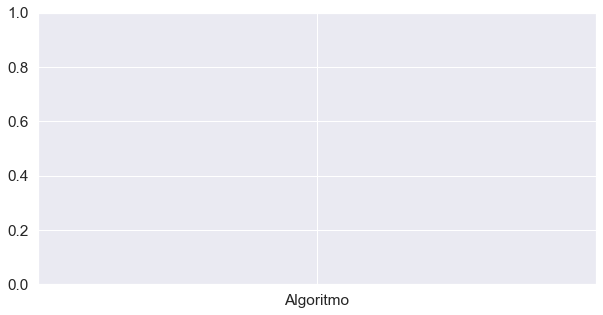

In [49]:

fig, ax  = plt.subplots(1,1, figsize = (10,5))

for resultado in resultados:
    #resultado.plot.bar(ax = ax, cmap = 'RdYlBu', edgecolor = "black")
    plt.bar(*zip(*resultado.items()))

ax.legend(loc = 'best')
ax.set_xlabel("Score")
ax.set_title("Cross validation model benchmark")

## Grid Search

In [ ]:
# Grid Search

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}

In [ ]:
text_clf = RandomForestClassifier(n_estimators=500, n_jobs=1)
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [ ]:
gs_clf.fit(X_train, y_train.values.ravel())

In [ ]:
# Melhor Resultado
gs_clf.best_score_

In [ ]:
# Melhores Parametros
for param_name in sorted(parameters.keys()):
     print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

In [ ]:
predicted = gs_clf.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predicted, target_names=y_nomes)) 

In [ ]:
# Coleta Resultados
resultados = []
resultado = {
    'Algoritmo': 'Passive-Aggressive',
    'Acurácia': 0.91,
    'Precisão': 0.91,
    'Recall': 0.91,
    'f1-score': 0.91
}
resultados.append(resultado)

#  Plot

In [ ]:
from functools import reduce

def _get_model_name(model):
    """
            Returns a string with the name of a sklearn model
                model: Sklearn stimator class
    """
    if isinstance(model, Pipeline):
        estimator = model.steps[-1][1]
        name = "Pipeline_" + str(estimator)[:str(estimator).find("(")]
    else: 
        name = str(model)[:str(model).find("(")]
    return name
    
    
def plot_cv_score(X, y, models_list, cv = 5, scoring_list = None, refit = True, return_scores = False):
    """ 
            X: numpy_array/pandas dataframe n_rows, m_features
            y: numpy_array/pandas dataframe n_rows
            Plots min, max and avg kfold crosval_score for a list of models
        
    """
    names, mean_score = list(), list()
    ldf = list()
    mnames = list()
    
    for i, model in enumerate(models_list):
        name = _get_model_name(model)
        print (name)
        clf = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clf',  model),
            ])

        if refit:
            clf.fit(X, y)
        for metric in score_list:
            score = cross_val_score(clf, X, y, cv = cv, scoring = metric, n_jobs= -1)
            mean_score.append(np.mean(score))
        tmp = pd.DataFrame({name: mean_score}, index = score_list)
        ldf.append(tmp)
        mean_score = list()
        
    frame_scores = reduce(lambda x,y: pd.merge(x,y, left_index = True, right_index = True), ldf).T
    fig, ax  = plt.subplots(1,1, figsize = (10,5))

    frame_scores.plot.bar(ax = ax, cmap = 'RdYlBu', edgecolor = "black")
    ax.legend(loc = 'best')
    ax.set_xlabel("Score")
    ax.set_title("Cross validation model benchmark")

    if return_scores:    
        return frame_scores

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

#X, y = load_breast_cancer(return_X_y= True)

models_list =[PassiveAggressiveClassifier(), #LogisticRegression(random_state= 42),
              SVC(probability= True),
              RandomForestClassifier(random_state = 42),
              GaussianNB()]

score_list = ["roc_auc", "accuracy", "f1", "precision", "recall"]

t = plot_cv_score(X = X_train, y = y_train.values.ravel(), models_list = models_list, cv = 5, scoring_list = score_list, refit = True)

# Classificadores

In [ ]:
# um classificador linear que utiliza o Gradiente Descendente Estocástico como método de treino. 
# Por padrão, utiliza o estimador SVM.
from sklearn.linear_model import SGDClassifier
# Uma rede neural Perceptron Multicamadas
from sklearn.neural_network import MLPClassifier

In [ ]:
classificadores = {
    'SVM': SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None),
    'SGD': SGDClassifier(max_iter=5),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier()
}

In [ ]:
cls_stats = {}
for cls_name in classificadores:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

In [ ]:

total_vect_time = 0
for cls_name, cls in classificadores.items():
	tick = time.time()

	ppl = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', cls),
	 ])
	
	print (cls_name)
	ppl.fit(X_train, y_train.values.ravel())

	# accumulate test accuracy stats
	cls_stats[cls_name]['total_fit_time'] = time.time() - tick
	cls_stats[cls_name]['n_train'] = X_train.shape[0]
	#cls_stats[cls_name]['n_train_pos'] += sum(y_train)
	tick = time.time()
	cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test) 
	cls_stats[cls_name]['prediction_time'] = time.time() - tick
	acc_history = (cls_stats[cls_name]['accuracy'], cls_stats[cls_name]['n_train'])
	cls_stats[cls_name]['accuracy_history'].append(acc_history)
	run_history = (cls_stats[cls_name]['accuracy'], total_vect_time + cls_stats[cls_name]['total_fit_time'])
	cls_stats[cls_name]['runtime_history'].append(run_history)

	print (cls_name)

# Out of Core

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
import itertools

In [ ]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               alternate_sign=False)


# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
#all_classes = np.array([0, 1])
#positive_class = 'acq'
all_classes = y_nomes

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(max_iter=5),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}

In [ ]:
def get_minibatch(doc_iter, size): #, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    #data = [('{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
    #        for doc in itertools.islice(doc_iter, size)
    #        if doc['topics']]
    # NovaDescricao Classificacao
    
    data = doc_iter.iloc[:size,:]

    #if not len(data):
    #    return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text = data['NovaDescricao'] 
    y = data['Categoria']
    return X_text, np.asarray(y) #, dtype=int)

def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)

In [ ]:
# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(dfAjustado, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
#test_stats['n_test_pos'] += sum(y_test)
#print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))
print("Test set is %d documents" % (len(y_test)))

In [ ]:
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s

In [ ]:

cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(dfAjustado, n_test_documents)
# Discard test set

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(dfAjustado, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batches of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        #cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')